In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import time
from sklearn.preprocessing import MinMaxScaler



import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from vus.utils.slidingWindows import find_length
from vus.utils.metrics import metricor

from vus.models.distance import Fourier
from vus.models.feature import Window
from vus.models.cnn import cnn
from vus.models.AE_mlp2 import AE_MLP2
from vus.models.lstm import lstm
from vus.models.ocsvm import OCSVM
from vus.models.poly import POLY
from vus.models.pca import PCA
from vus.models.norma import NORMA
from vus.models.matrix_profile import MatrixProfile
from vus.models.lof import LOF
from vus.models.iforest import IForest

from vus.analysis.score_computation import generate_data,compute_score
from vus.analysis.robustness_eval import compute_anomaly_acc_lag,compute_anomaly_acc_percentage,compute_anomaly_acc_noise,normalize_dict_exp,group_dict,box_plot,generate_curve



/opt/anaconda3/lib/python3.8/site-packages/tslearn/clustering/kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


# Training anomaly detection model

In this example, we train 2 different model on the MBA(805) dataset, which is a dataset with easy to detect anomalies. For this visualisation, we choose the 20,000 first points. 

In [4]:
import os
all_files = [] 
for file in os.listdir('../../data'):
    all_files.append('../../data/{}'.format(file))

In [15]:
import json
import pickle

def generate_data(filepath,init_pos,max_length):
    
    df = pd.read_csv(filepath, header=None).to_numpy()
    name = filepath.split('/')[-1]
    data = df[init_pos:init_pos+max_length,0].astype(float)
    label = df[init_pos:init_pos+max_length,1]
    data = df[0:max_length,0].astype(float)
    label = df[0:max_length,1]
    slidingWindow = find_length(data)
    #slidingWindow = 70
    X_data = Window(window = slidingWindow).convert(data).to_numpy()
    data_train = data[:int(0.1*len(data))]
    data_test = data
    X_train = Window(window = slidingWindow).convert(data_train).to_numpy()
    X_test = Window(window = slidingWindow).convert(data_test).to_numpy()
    
    return slidingWindow,data,X_data,data_train,data_test,X_train,X_test,label

methods = [
    'NormA',
    'POLY',
    'IForest',
    'AE',
    'OCSVM',
    'MatrixProfile',
    'LOF',
    'LSTM',
    'CNN',
]

max_length = 20000
filepath = '../../data/MBA_ECG805_data.out'



slidingWindow,data,X_data,data_train,data_test,X_train,X_test,label = generate_data(filepath,0,max_length)
methods_scores =  compute_score(methods,slidingWindow,data,X_data,data_train,data_test,X_train,X_test)

In [16]:
to_keep = ['OCSVM','AE']
new_methods_scores = {}
for key in methods_scores.keys():
    if key in to_keep:
        new_methods_scores[key] = methods_scores[key]

methods_scores = new_methods_scores

# Visualization of the accuracy metric

In this example we visualize the differnt accuracy metric applied on a specific snippet of a specific data set.

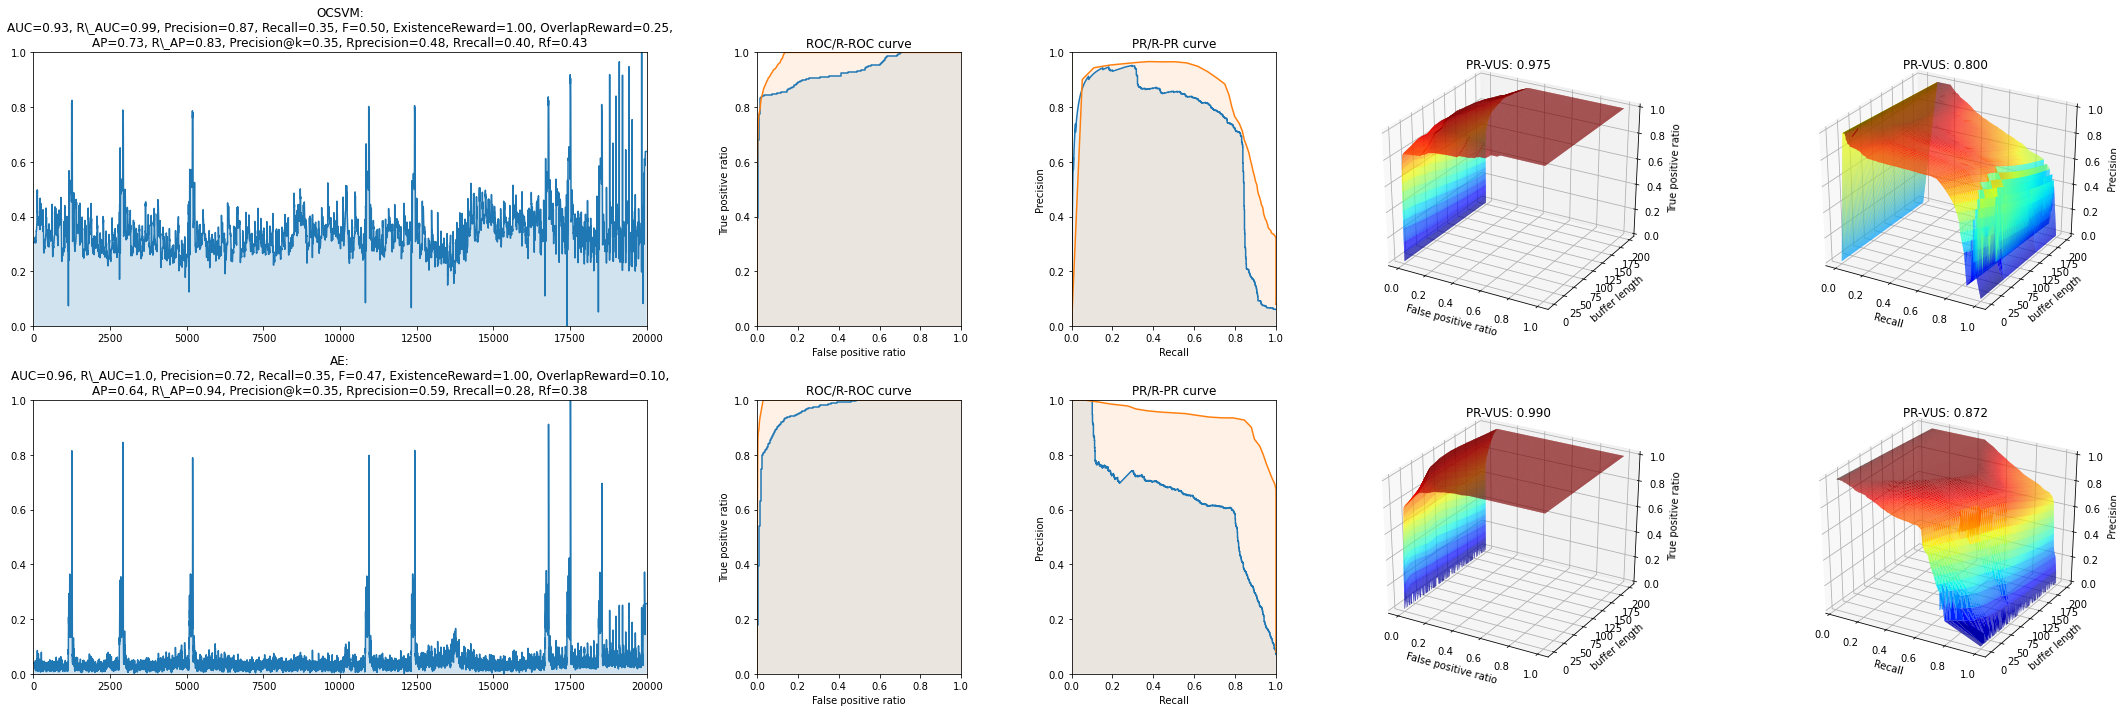

In [17]:
all_per_acc = []
f, grid = plt.subplots(len(methods_scores.keys()), 5, gridspec_kw={'width_ratios': [3, 1,1,1.5,1.5]},figsize=(30,10))
for i,methods_score in enumerate(tqdm(to_keep)):

    grader = metricor()  
    R_AUC, R_AP, R_fpr, R_tpr, R_prec = grader.RangeAUC(labels=label, score=methods_scores[methods_score], window=slidingWindow, plot_ROC=True) 
    L, fpr, tpr= grader.metric_new(label, methods_scores[methods_score], plot_ROC=True)
    precision, recall, AP = grader.metric_PR(label, methods_scores[methods_score])  
    range_anomaly = grader.range_convers_new(label)

    grid[i,1].plot(fpr,tpr)
    grid[i,1].fill_between(fpr,tpr,alpha=0.1)
    grid[i,1].plot(R_fpr,R_tpr)
    grid[i,1].fill_between(R_fpr,R_tpr,alpha=0.1)
    grid[i,1].set_xlim(0,1)
    grid[i,1].set_ylim(0,1)
    grid[i,1].set_title("ROC/R-ROC curve")
    grid[i,1].set_xlabel('False positive ratio')
    grid[i,1].set_ylabel('True positive ratio')

    grid[i,2].plot(recall,precision)
    grid[i,2].fill_between(recall,precision,alpha=0.1)
    grid[i,2].plot(R_tpr[:-1],R_prec)
    grid[i,2].fill_between(R_tpr[:-1],R_prec,alpha=0.1)
    grid[i,2].set_xlim(0,1)
    grid[i,2].set_ylim(0,1)
    grid[i,2].set_title("PR/R-PR curve")
    grid[i,2].set_xlabel('Recall')
    grid[i,2].set_ylabel('Precision')


    Y, Z, X, X_ap, W, Z_ap,avg_auc_3d, avg_ap_3d = generate_curve(label,methods_scores[methods_score],2*slidingWindow)

    grid[i,3].remove()
    ax = f.add_subplot(len(methods_scores.keys()), 5,i*5+4,projection='3d')
    ax.plot_trisurf(Y, Z, X, cmap=cm.jet, linewidth=0.1)
    ax.set_xlabel('False positive ratio')
    ax.set_zlabel('True positive ratio')
    ax.set_ylabel('buffer length')  
    ax.set_title("PR-VUS: {:.3f}".format(avg_auc_3d))

    grid[i,4].remove()
    ax = f.add_subplot(len(methods_scores.keys()), 5,i*5+5,projection='3d')
    ax.plot_trisurf(W, Z_ap, X_ap, cmap=cm.jet, linewidth=0.1)
    ax.set_xlabel('Recall')
    ax.set_zlabel('Precision')
    ax.set_ylabel('buffer length')  
    ax.set_title("PR-VUS: {:.3f}".format(avg_ap_3d))

    
    grid[i,0].plot(methods_scores[methods_score])
    grid[i,0].fill_between([j for j in range(len(methods_scores[methods_score]))],methods_scores[methods_score],alpha=0.2)
    grid[i,0].set_title(methods_score)
    grid[i,0].set_xlim(0,len(methods_scores[methods_score]))
    grid[i,0].set_ylim(0,max(methods_scores[methods_score]))


    L1 = [ '%.2f' % elem for elem in L]
    L_val = [ elem for elem in L]
    L_return = [avg_auc_3d,avg_ap_3d,round(R_AUC,2),round(R_AP,2),L_val[0],round(AP,2),L_val[8],L_val[7],L_val[4],L_val[3],L_val[1],L_val[2],L_val[9]]
    L_return_name = ['VUS-AUC','VUS-PR','R-AUC-ROC','R-AUC-PR','AUC-ROC','AUC-PR','RF','Rprecision','Rrecall','F','Precision','Recall','Precision@k']
    
    grid[i,0].set_title(methods_score
    +':\nAUC='+L1[0]+', R\_AUC='+str(round(R_AUC,2))+', Precision='+L1[1]+ ', Recall='+L1[2]+', F='+L1[3]
    + ', ExistenceReward='+L1[5]+', OverlapReward='+L1[6]
    +',\nAP='+str(round(AP,2))+', R\_AP='+str(round(R_AP,2))+', Precision@k='+L1[9]+', Rprecision='+L1[7] + ', Rrecall='+L1[4] +', Rf='+L1[8]
    )
    
    all_per_acc.append(L_return)
    
f.tight_layout()


## Visualization of a snippet

In this snippet, we notice that AE is more accurate than OCSVM (anomalies are easily identifable using AE score than  using OCSVM score). However, we observe that most of the usual accuracy measures are considering OCSVM as the most accurate. This is not true (which is confirmed in the following figure in which we can observe false positives at the end of the xaxis on the OCSVM score). The last plot is demonstrating that, most of the time (due to randomness in the score computation of AE and OCSVM it migh varies in differnt cases), only the range and VUS-based measures are ranking correctly the two methods.

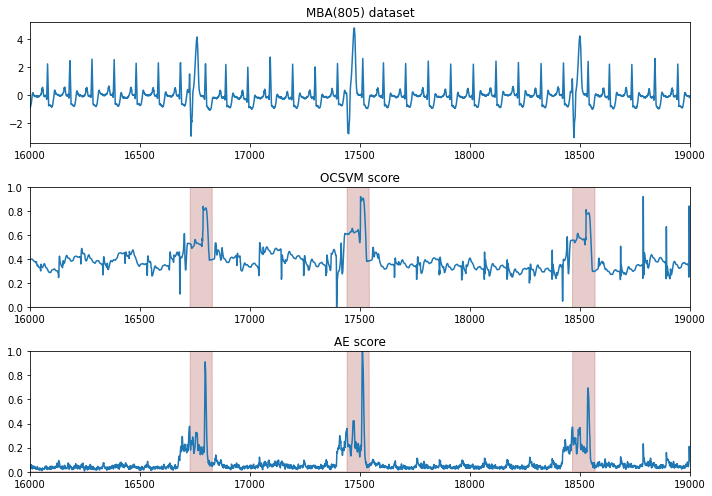

In [26]:
plt.figure(figsize=(10,7))
plt.subplot(3,1,1)
plt.plot(data)
#plt.xticks([],[])
plt.title("MBA(805) dataset")
plt.xlim(16000,19000)
#plt.ylim(0,1)
plt.subplot(3,1,2)
plt.plot(methods_scores[to_keep[0]])
plt.fill_between(list(range(len(label))),[0 for i in range(len(label))],label,color='darkred',alpha=0.2)
#plt.xticks([],[])
plt.title("OCSVM score")
plt.xlim(16000,19000)
plt.ylim(0,1)
plt.subplot(3,1,3)
plt.plot(methods_scores[to_keep[1]])
plt.fill_between(list(range(len(label))),[0 for i in range(len(label))],label,color='darkred',alpha=0.2)
plt.xlim(16000,19000)
plt.title("AE score")
plt.ylim(0,1)
#plt.xticks([],[])
plt.tight_layout()



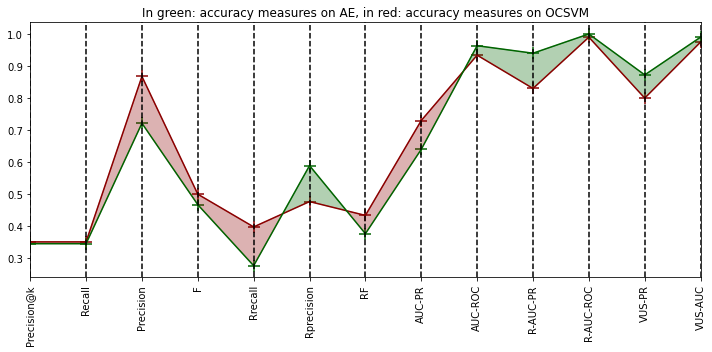

In [25]:
plt.figure(figsize=(10,5))
plt.plot(all_per_acc[0][::-1],color='darkred')
plt.scatter(list(range(len(all_per_acc[0]))),all_per_acc[0][::-1],s=150,marker='+',c='darkred')
plt.plot(all_per_acc[1][::-1],color='darkgreen')
plt.scatter(list(range(len(all_per_acc[0]))),all_per_acc[1][::-1],s=150,marker='+',c='darkgreen')

plt.fill_between(list(range(len(all_per_acc[0]))), all_per_acc[0][::-1], all_per_acc[1][::-1], where=(np.array(all_per_acc[0][::-1]) > np.array(all_per_acc[1][::-1])), color='darkred', alpha=0.3,interpolate=True)
plt.fill_between(list(range(len(all_per_acc[0]))), all_per_acc[0][::-1], all_per_acc[1][::-1], where=(np.array(all_per_acc[0][::-1]) < np.array(all_per_acc[1][::-1])), color='darkgreen', alpha=0.3,interpolate=True)

for index in list(range(len(all_per_acc[0]))):
    plt.axvline(x=index,c='black',linestyle='--')

plt.xticks(list(range(len(all_per_acc[0]))),L_return_name[::-1],rotation=90)
plt.xlim(0,len(all_per_acc[1])-1)

plt.title("In green: accuracy measures on AE, in red: accuracy measures on OCSVM")

plt.tight_layout()